1. Обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики


In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func


    def __getitem__(self, idx):
        point = self.x[idx]
        return torch.Tensor([point, self.func(point)])


    def __len__(self):
        return self.num

In [4]:
def func(x):
    return np.sin(x) / x - x / 10

In [5]:
min_ = -15
max_ = 15
num_ = 10000

In [9]:
data = Data(func, min_, max_, num_)
data[0]

tensor([-2.0080,  0.6520])

In [10]:
data_loader = DataLoader(data, batch_size=1000, shuffle=True)

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()
        
        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 2)


    def forward(self, x):
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.linear_2(x)      
        return x

In [12]:
class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()

    self.linear_1 = nn.Linear(2, hidden_dim)
    self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
    self.linear_3 = nn.Linear(hidden_dim // 2, 1)


  def forward(self, x): 
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = torch.relu(x)
    x = self.linear_3(x)
    x = torch.sigmoid(x)
    return x

In [13]:
n_epochs = 1000
lr = 0.01

b1 = 0.5
b2 = 0.999

latent_dim = 1
hidden_dim = 64

In [14]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)
optimizer_G = torch.optim.Adam(    
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)   
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)
adversarial_loss = torch.nn.BCELoss()

In [15]:
d_loss_history = []
g_loss_history = []

Epoch: 10; Discriminator_loss: 0.686; Generator_loss: 0.709


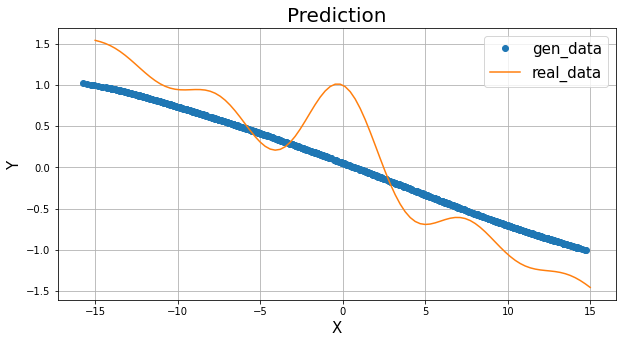

Epoch: 20; Discriminator_loss: 0.643; Generator_loss: 0.84


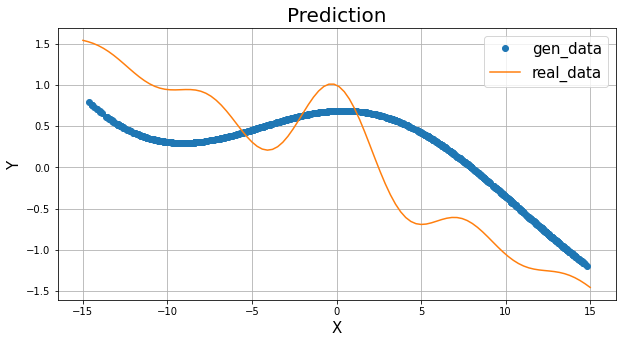

Epoch: 30; Discriminator_loss: 0.643; Generator_loss: 0.839


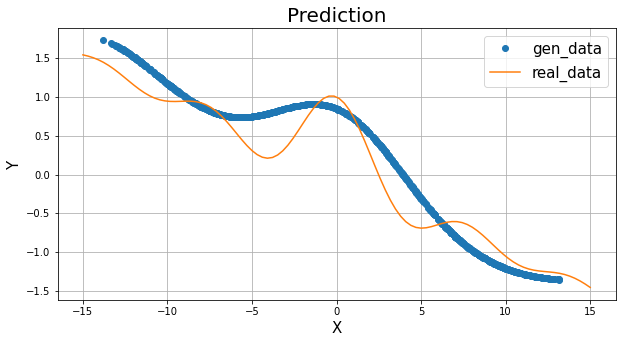

Epoch: 40; Discriminator_loss: 0.658; Generator_loss: 0.841


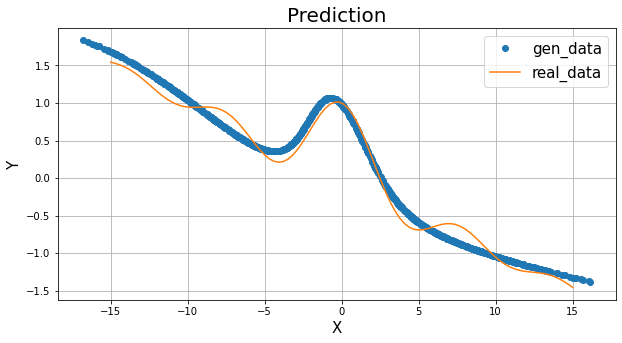

Epoch: 50; Discriminator_loss: 0.676; Generator_loss: 0.744


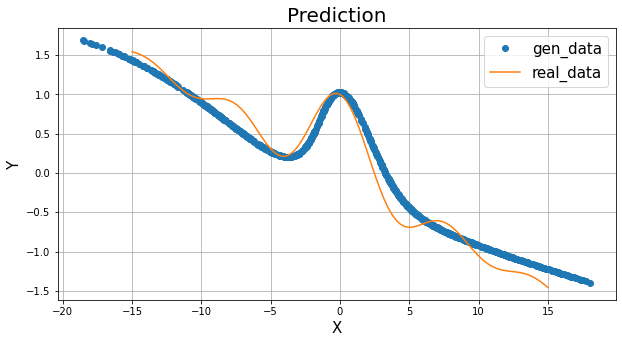

Epoch: 60; Discriminator_loss: 0.676; Generator_loss: 0.776


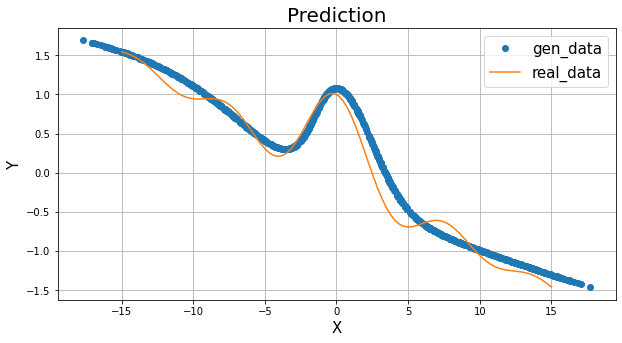

Epoch: 70; Discriminator_loss: 0.657; Generator_loss: 0.912


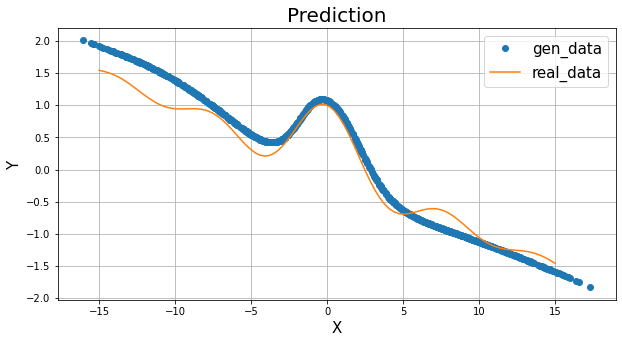

Epoch: 80; Discriminator_loss: 0.665; Generator_loss: 0.819


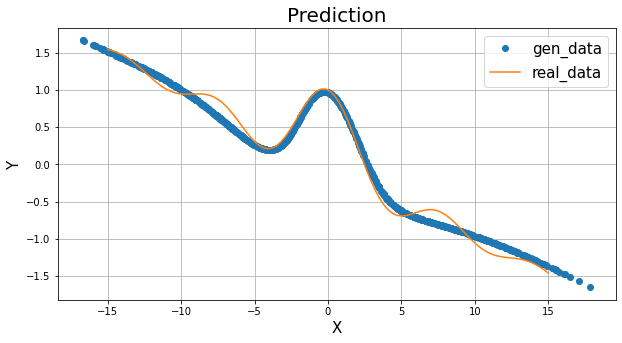

Epoch: 90; Discriminator_loss: 0.664; Generator_loss: 0.801


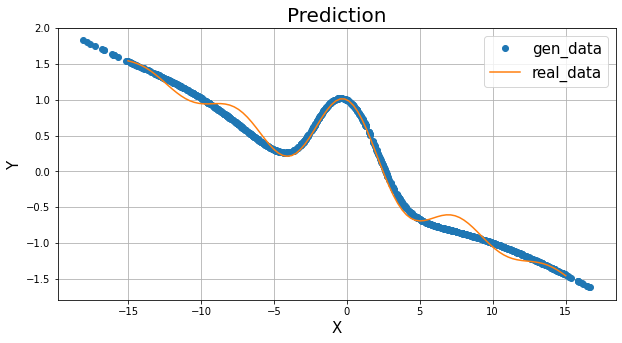

Epoch: 100; Discriminator_loss: 0.665; Generator_loss: 0.81


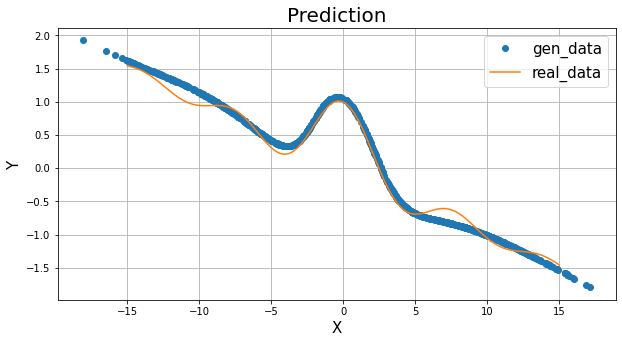

Epoch: 200; Discriminator_loss: 0.641; Generator_loss: 0.895


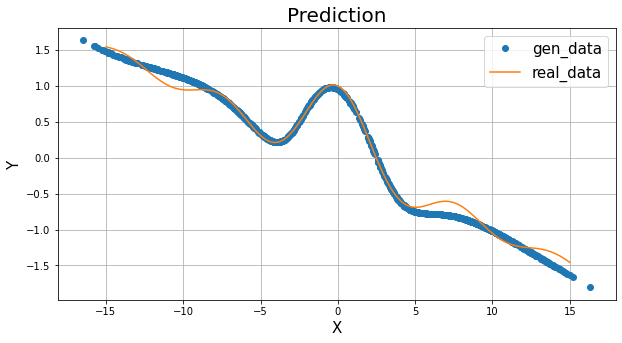

Epoch: 300; Discriminator_loss: 0.63; Generator_loss: 1.056


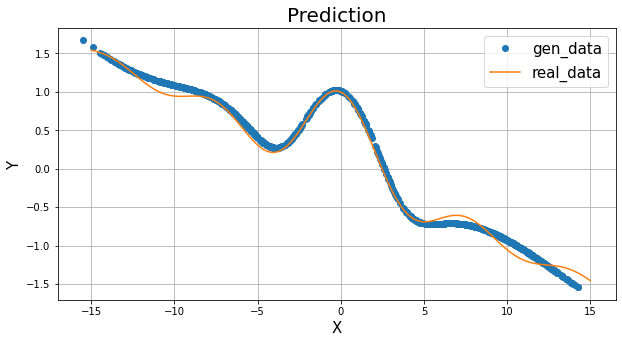

Epoch: 400; Discriminator_loss: 0.635; Generator_loss: 0.976


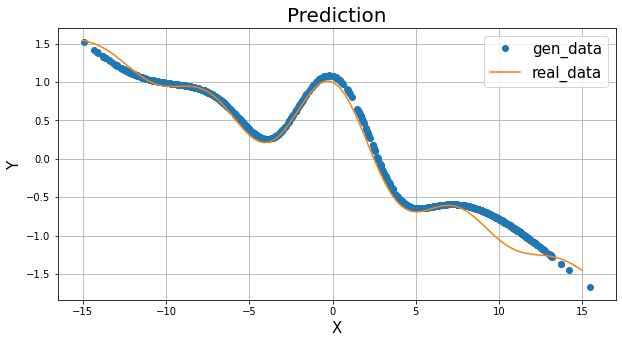

Epoch: 500; Discriminator_loss: 0.571; Generator_loss: 1.592


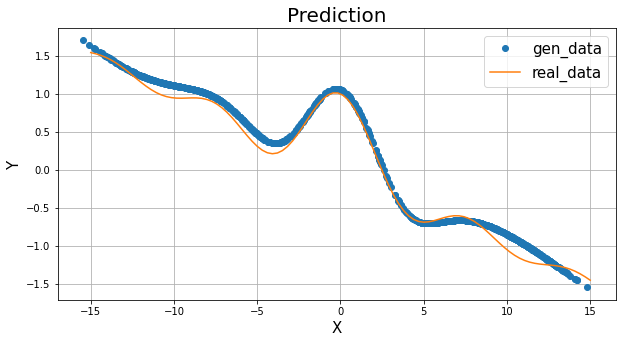

Epoch: 600; Discriminator_loss: 0.621; Generator_loss: 1.118


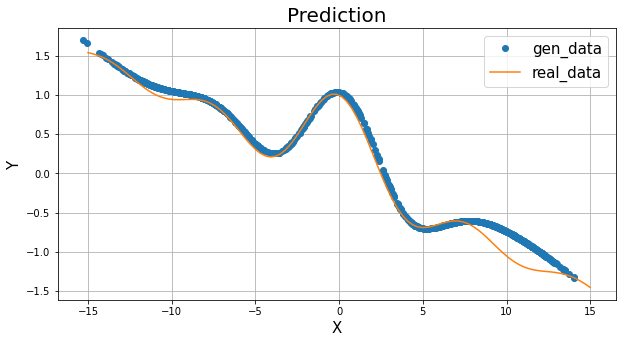

Epoch: 700; Discriminator_loss: 0.621; Generator_loss: 1.225


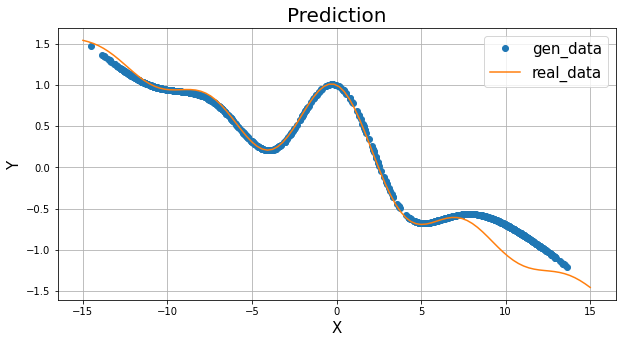

Epoch: 800; Discriminator_loss: 0.545; Generator_loss: 1.512


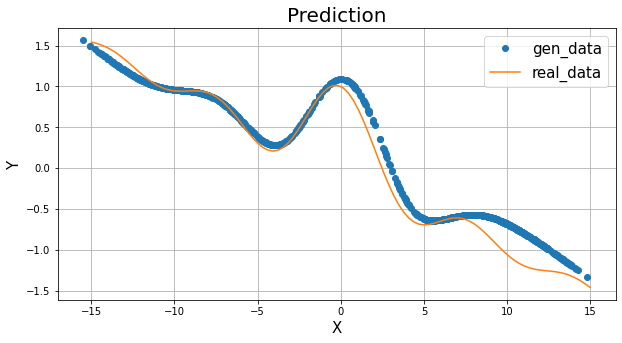

Epoch: 900; Discriminator_loss: 0.587; Generator_loss: 1.359


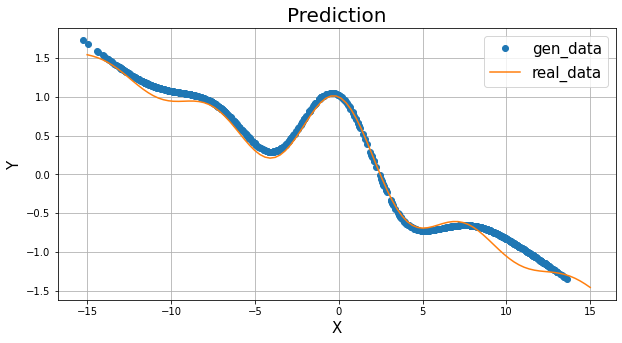

Epoch: 1000; Discriminator_loss: 0.629; Generator_loss: 1.028


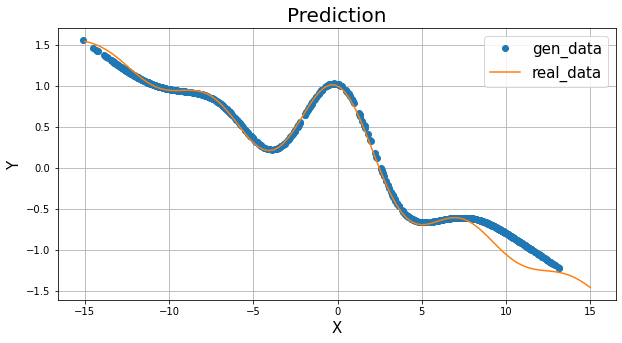

In [16]:
for epoch in range(n_epochs):    
    d_loss_mean = 0.0
    g_loss_mean = 0.0
    for data in data_loader:
        batch_size = len(data)
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)
        real_data = data.type(torch.Tensor).to(device)
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device) 
        gen_data = generator(z)
        real_pred = discriminator(real_data)
        d_real_loss = adversarial_loss(real_pred, valid)
        fake_pred = discriminator(gen_data)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        gen_data = generator(z)
        fake_pred = discriminator(gen_data)
        g_loss = adversarial_loss(fake_pred, valid)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()
    if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
        print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
        plt.figure(figsize = (10,5))
        plt.title('Prediction', fontsize = 20)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 15)
        plt.xlabel('X', fontsize = 15)
        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')
        plt.plot(np.linspace(min_, max_, 100), func(np.linspace(min_, max_, 100)), label='real_data')

        plt.legend(fontsize = 15)
        plt.show()
    
    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))       

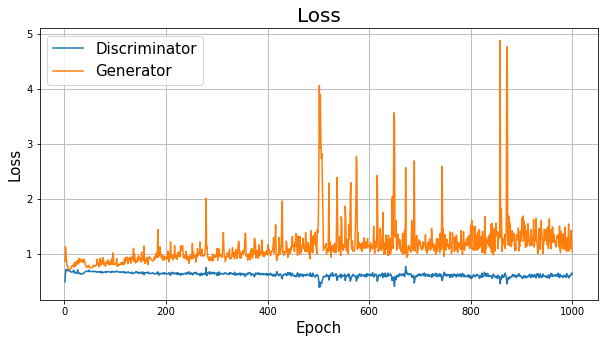

In [17]:
plt.figure(figsize = (10,5))
plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15)